In [1]:
import os
import pickle

import scipy.io as sio
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.utils as tutils
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as tv_transforms
import torchvision.utils as vutils
import torchvision.datasets as tv_datasets
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda:0


# PCA with Cifar10

In [ ]:
checkpoint = torch.load("data/cifar-100-python/res50_feas_resized.tar")
train_feature = checkpoint["x_train"]
test_feature = checkpoint["x_valid"]
print(train_feature.size())
print(test_feature.size())
print(checkpoint.keys())

In [ ]:
minmax_scaler = preprocessing.MinMaxScaler()
train_feature = minmax_scaler.fit_transform(train_feature)
test_feature = minmax_scaler.transform(test_feature)

scaler = preprocessing.StandardScaler()
train_feas = scaler.fit_transform(train_feature)
test_feas = scaler.transform(test_feature)

num_comp = 0.1
pca_fcn = PCA(num_comp).fit(train_feas)
train_pca = pca_fcn.transform(train_feas)
test_pca = pca_fcn.transform(test_feas)

inv_train = pca_fcn.inverse_transform(train_pca)
inv_test = pca_fcn.inverse_transform(test_pca)

In [ ]:
torch.save({"train_x": inv_train,
            "test_x": inv_test,
            "test_y": checkpoint['y_valid'],
            "train_y": checkpoint['y_train']}, 
            f"data/cifar-100-python/pca{int(num_comp*2048)}.tar")

# Initialize Pre-trained Feature Extractor

In [ ]:
import torchvision.models as models

model = models.resnet101(pretrained=True)
model.fc = nn.Identity()
# model.maxpool = nn.Identity()
# model.avgpool = nn.Identity()
model = model.to(device)

In [ ]:
import torchvision.models as models
model = models.vgg16(pretrained=True)
# model.fc = nn.Identity()
# model.maxpool = nn.Identity()
# model.avgpool = nn.Identity()
model = model.to(device)

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained("efficientnet-b7")
model = model.to(device)

# One-Time Feature Extraction

For CIFAR10/100.

NOT Using Resnet56 from, https://github.com/akamaster/pytorch_resnet_cifar10

In [ ]:
img_trans = tv_transforms.Compose([
#                                    tv_transforms.ToPILImage(),
                                   tv_transforms.Resize(224),
                                   tv_transforms.ToTensor(),
                                   tv_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])


In [ ]:
mb_size = 32
model.eval()
train_feas = []
train_labels = []
cifar100 = tv_datasets.CIFAR10("data", train=True, transform=img_trans, download=True)
dataloader = DataLoader(cifar100, batch_size=mb_size, num_workers=4)
with torch.no_grad():
    for x_mb, y_mb in dataloader:
#         feas_out = model(x_mb.to(device))
        feas_out = model._avg_pooling(model.extract_features(x_mb.to(device)))
        train_labels.append(y_mb.numpy())
        train_feas.append(feas_out.view(x_mb.size(0),-1).detach().cpu())

    train_feas = torch.cat(train_feas, dim=0)
    y_train = np.concatenate(train_labels)
    
test_feas = []
test_labels = []
cifar100 = tv_datasets.CIFAR10("data", train=False, transform=img_trans, download=True)
dataloader = DataLoader(cifar100, batch_size=mb_size, num_workers=4)
with torch.no_grad():
    for x_mb, y_mb in dataloader:
#         feas_out = model(x_mb.to(device))
        feas_out = model._avg_pooling(model.extract_features(x_mb.to(device)))
        test_labels.append(y_mb.numpy())
        test_feas.append(feas_out.view(x_mb.size(0),-1).detach().cpu())

    test_feas = torch.cat(test_feas, dim=0)
    y_valid = np.concatenate(test_labels)
    
print(f"train_feas: {train_feas.size()}")
print(f"train_labels: {y_train.shape}")
print(f"test_feas: {test_feas.size()}")
print(f"test_label: {y_valid.shape}")

In [ ]:
torch.save({"x_train": train_feas.cpu().detach(),
            "x_valid": test_feas.cpu().detach(),
            "y_train": torch.from_numpy(y_train).long(),
            "y_valid": torch.from_numpy(y_valid).long()}, 
#            "data/cifar-100-python/efficientb7_feas_resized.tar")
           "data/cifar-10-batches-py/efficientb7_feas_resized.tar")

# Feature Extraction for ImageNet

In [2]:
import glob
import torchvision.models as models
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
from pipeline.imagenet_dataset import TrainDataset

model = models.resnet18(pretrained=True)
# model.load_state_dict(torch.load("imagenet500_res18_72.pth")["model"])
model.fc = nn.Identity()
model = model.to(device)

In [17]:
import timm

model = timm.create_model("resnet18", pretrained=True)
model.fc = nn.Identity()
model = model.to(device)

In [18]:
DATADIR = os.path.expanduser("~/project/data/ILSVR2012/")
train_data_path = os.path.join(DATADIR,"train")
val_data_path = os.path.join(DATADIR,"val")

# Select the first 500
class_lst = glob.glob(os.path.join(train_data_path,'*'))
label_map = {key.split("/")[-1]: idx for idx, key in enumerate(class_lst)}

train_img_path = [glob.glob(f"{apth}/*.JPEG") for apth in class_lst]
train_img_path = [img for apth in train_img_path for img in apth]

valid_img_path = []

for each_key in label_map.keys():
    val_path = os.path.join(val_data_path, each_key)
    valid_img_path.append(glob.glob(f"{val_path}/*.JPEG"))
valid_img_path = [img for apth in valid_img_path for img in apth]

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0, max_pixel_value=255.0,
)

valid_transform = transforms.Compose([transforms.Resize(256, 256), transforms.CenterCrop(224,224), normalize, ToTensorV2()], p=1.0)

train_ds = TrainDataset(train_img_path, label_map, transform=valid_transform)
valid_ds = TrainDataset(valid_img_path, label_map, transform=valid_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)
valid_loader = DataLoader(
    valid_ds,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)


In [19]:
model.eval()
train_feas = []
train_labels = []
store_step = 400
for idx, (x_mb, y_mb) in enumerate(train_loader):
    x_mb = x_mb.to(device)
    feas = model(x_mb)
    train_feas.append(feas.detach().cpu())
    train_labels.append(y_mb)
    if (idx+1) % 25 == 0 or (idx+1) == len(train_loader):
        train_feas = torch.cat(train_feas, dim=0)
        train_labels = torch.cat(train_labels, dim=0)
        print(idx)
        print(f"feas size - {train_feas.shape}")
        print(f"label size - {train_labels.shape}")
        torch.save({"x_train": train_feas.cpu().detach(),
                    "y_train": train_labels.long()}, 
                   f"data/imagenet/train/resnet18_feas_{idx//25}.tar")
        train_feas = []
        train_labels = []



24
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
49
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
74
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
99
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
124
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
149
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
174
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
199
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
224
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
249
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
274
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
299
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
324
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
349
feas size - torch.Size([12800, 512])
l

In [20]:
class_lst = glob.glob(os.path.join("data/imagenet/train",'resnet18_feas_*.tar'))

valid_data = []
for file_idx, afile in enumerate(class_lst):
    print(f"working file {file_idx}")
    checkpoint = torch.load(afile)
    x_feas = checkpoint["x_train"]
    y_label = checkpoint["y_train"]
    all_data = torch.cat([x_feas, y_label.unsqueeze(1)], dim=1)
    valid_data.append(all_data)

valid_data = torch.cat(valid_data, dim=0)
# valid_data = np.concatenate(valid_data, axis=0)
print(valid_data.shape)
torch.save({"train_data": valid_data}, "data/imagenet/train/train_data_new.tar")
# np.save("data/imagenet/val/valid_data.npy", valid_data)

working file 0
working file 1
working file 2
working file 3
working file 4
working file 5
working file 6
working file 7
working file 8
working file 9
working file 10
working file 11
working file 12
working file 13
working file 14
working file 15
working file 16
working file 17
working file 18
working file 19
working file 20
working file 21
working file 22
working file 23
working file 24
working file 25
working file 26
working file 27
working file 28
working file 29
working file 30
working file 31
working file 32
working file 33
working file 34
working file 35
working file 36
working file 37
working file 38
working file 39
working file 40
working file 41
working file 42
working file 43
working file 44
working file 45
working file 46
working file 47
working file 48
working file 49
working file 50
working file 51
working file 52
working file 53
working file 54
working file 55
working file 56
working file 57
working file 58
working file 59
working file 60
working file 61
working file 62
wo

In [21]:
valid_feas = []
valid_labels = []
for idx, (x_mb, y_mb) in enumerate(valid_loader):
    x_mb = x_mb.to(device)
    feas = model(x_mb)
    valid_feas.append(feas.detach().cpu())
    valid_labels.append(y_mb)
    if (idx+1) % 25 == 0 or (idx+1) == len(valid_loader):
        valid_feas = torch.cat(valid_feas, dim=0)
        valid_labels = torch.cat(valid_labels, dim=0)
        print(idx+1)
        print(f"feas size - {valid_feas.shape}")
        print(f"label size - {valid_labels.shape}")
        torch.save({"x_valid": valid_feas.cpu().detach(),
                    "y_valid": valid_labels.long()}, 
                   f"data/imagenet/val/resnet18_feas_{idx//25}.tar")
        valid_feas = []
        valid_labels = []

# valid_feas = torch.cat(valid_feas, dim=0)
# valid_labels = torch.cat(valid_labels, dim=0)
# print(f"feas size - {valid_feas.shape}")
# print(f"label size - {valid_labels.shape}")
# print(f"unique - {np.unique(valid_labels.numpy()).shape[0]}")

25
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
50
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
75
feas size - torch.Size([12800, 512])
label size - torch.Size([12800])
98
feas size - torch.Size([11600, 512])
label size - torch.Size([11600])


In [22]:
class_lst = glob.glob(os.path.join("data/imagenet/val",'resnet18_feas_*.tar'))

valid_data = []
for file_idx, afile in enumerate(class_lst):
    print(f"working file {file_idx}")
    checkpoint = torch.load(afile)
    x_feas = checkpoint["x_valid"]
    y_label = checkpoint["y_valid"]
    all_data = torch.cat([x_feas, y_label.unsqueeze(1)], dim=1)
    valid_data.append(all_data)

valid_data = torch.cat(valid_data, dim=0)
print(valid_data.shape)
torch.save({"valid_data": valid_data}, "data/imagenet/val/valid_data_new.tar")

working file 0
working file 1
working file 2
working file 3
torch.Size([50000, 513])


# Load Extracted Features

In [ ]:
checkpoint = torch.load("data/cifar-10-batches-py/res50_feas_resized.tar")
# checkpoint = torch.load("data/cifar-100-python/res50_feas_resized.tar")
x_train = checkpoint["x_train"].numpy()
x_valid = checkpoint["x_valid"].numpy()

y_train = checkpoint['y_train']
y_valid = checkpoint["y_valid"]

scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_train = torch.from_numpy(x_train)
x_valid = torch.from_numpy(x_valid)

In [2]:
checkpoint = torch.load(f"data/imagenet/train/train_data.tar")
x_train = checkpoint["train_data"].numpy()[:,:-1]
y_train = checkpoint['train_data'][:,-1].long()  # long tensor
checkpoint = torch.load(f"data/imagenet/val/valid_data.tar")
x_valid = checkpoint["valid_data"].numpy()[:,:-1]
y_valid = checkpoint["valid_data"][:,-1].long()  # long tensor

scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_train = torch.from_numpy(x_train)
x_valid = torch.from_numpy(x_valid)

In [3]:
mask0 = y_train >= 0
mask1 = y_train < 500
mask = mask0 * mask1
task_train_x = x_train[mask]
task_train_y = y_train[mask]

mask0 = y_valid >= 0
mask1 = y_valid < 500
mask = mask0 * mask1
task_test_x = x_valid[mask]
task_test_y = y_valid[mask]

In [4]:
from models.gen_model import LinearCLS

mb_size = 512
linear_cls = LinearCLS(x_train.size(1), 1000).to(device)
optimizer_cls = torch.optim.Adam(linear_cls.parameters(), lr=0.001, betas=(0.5, 0.999))
cls_criterion = nn.NLLLoss()


# Train Upper Bound Classifier

In [ ]:
from models.gen_model import LinearCLS

mb_size = 128
linear_cls = LinearCLS(train_feas.size(1), 50).to(device)
optimizer_cls = torch.optim.Adam(linear_cls.parameters(), lr=0.001, betas=(0.5, 0.999))
cls_criterion = nn.NLLLoss()

num_iter = train_feas.size(0) // mb_size
bd_indices = [ii for ii in range(0, train_labels.size(0), mb_size)]

for epc in range(40):
    batch_indices = np.random.permutation(np.arange(train_feas.size(0)))
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = train_feas[batch_idx].float().to(device)
        y_mb = train_labels[batch_idx].to(device)
        output = linear_cls(x_mb)
        loss = cls_criterion(output, y_mb)
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()


In [ ]:
linear_cls

In [5]:
mb_size = 512
num_iter = task_train_x.size(0) // mb_size
bd_indices = [ii for ii in range(0, task_train_x.size(0), mb_size)]

for epc in range(40):
    batch_indices = np.random.permutation(np.arange(task_train_x.size(0)))
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = task_train_x[batch_idx].float().to(device)
        y_mb = task_train_y[batch_idx].to(device)
        output = linear_cls(x_mb)
        loss = cls_criterion(output, y_mb)
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        
num_iter = task_test_x.size(0) // mb_size
bd_indices = [ii for ii in range(0, task_test_x.size(0), mb_size)]
batch_indices = np.arange(task_test_x.size(0))
corr = 0
with torch.no_grad():
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = task_test_x[batch_idx].float().to(device)
        y_mb = task_test_y[batch_idx].to(device)
        output = linear_cls(x_mb)
        pred = torch.argmax(output,dim=1)
        corr += torch.sum(torch.eq(y_mb, pred))

acc = 100*corr / float(task_test_x.size(0))
print(f"accuracy: {acc}")

accuracy: 73.08799743652344


In [ ]:
num_iter = valid_feas.size(0) // mb_size
bd_indices = [ii for ii in range(0, valid_feas.size(0), mb_size)]
batch_indices = np.arange(valid_feas.size(0))
corr = 0
with torch.no_grad():
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = valid_feas[batch_idx].float().to(device)
        y_mb = valid_labels[batch_idx].to(device)
        output = linear_cls(x_mb)
        pred = torch.argmax(output,dim=1)
        corr += torch.sum(torch.eq(y_mb, pred))

acc = 100*corr / float(valid_feas.size(0))
print(f"accuracy: {acc}")

# Visualization

In [ ]:
comp_percent = np.arange(1,10)*0.1
res_lst = []
for acount in comp_percent:
    pca_acc = []
    for idx in range(1,6):
        pca_res = np.genfromtxt(f"out/split-cifar100/supp/pca{int(2048*acount)}-nepoch-70/lin_acc_it0{idx}.txt", delimiter=",")
        pca_acc.append(np.mean(pca_res[-1])*0.01)
    res_lst.append(pca_acc)
    
pca_acc = []
for idx in range(1,6):
    pca_res = np.genfromtxt(f"out/split-cifar100/res50_feas_resized-nepoch70-nSample300-A5/cl_acc_it0{idx}.txt", delimiter=",")
    pca_acc.append(np.mean(pca_res[-1])*0.01)
res_lst.append(pca_acc)

In [ ]:
pca_count = [f"{idx*10}%" for idx in range(1,11)]
plt.figure(figsize=(10,7))
plt.boxplot(res_lst)

plt.xticks(np.arange(1,11), labels=pca_count, fontsize=20)
plt.xlabel("PCA Components", fontsize=24)
plt.ylabel(r"$A_{10}$", fontsize=25)
plt.yticks(fontsize=20)
plt.title(r"$A_T$ against PCA Components", fontsize=24)
plt.grid(True)
# plt.show()
plt.savefig("pca-cifar100.png",bbox_inches='tight')

In [11]:
res_1 = np.genfromtxt(f"out/split-cub/res101-nepoch30-nSample300-A10/cl_acc_it01.txt", delimiter=",")
mask = res_1 == 0
res_1[mask] = np.nan
arr_1 = np.nanmean(res_1, axis=1) / 100.

res_2 = np.genfromtxt(f"out/split-cub/res101-nepoch30-nSample300-A10/cl_acc_it02.txt", delimiter=",")
mask = res_2 == 0
res_2[mask] = np.nan
arr_2 = np.nanmean(res_2, axis=1) / 100.

res_3 = np.genfromtxt(f"out/split-cub/res101-nepoch30-nSample300-A10/cl_acc_it03.txt", delimiter=",")
mask = res_3 == 0
res_3[mask] = np.nan
arr_3 = np.nanmean(res_3, axis=1) / 100.

res_4 = np.genfromtxt(f"out/split-cub/res101-nepoch30-nSample300-A10/cl_acc_it04.txt", delimiter=",")
mask = res_4 == 0
res_4[mask] = np.nan
arr_4 = np.nanmean(res_4, axis=1) / 100.

res_5 = np.genfromtxt(f"out/split-cub/res101-nepoch30-nSample300-A10/cl_acc_it05.txt", delimiter=",")
mask = res_5 == 0
res_5[mask] = np.nan
arr_5 = np.nanmean(res_5, axis=1) / 100.

all_res = np.concatenate([arr_1.reshape(1,-1),
                          arr_2.reshape(1,-1),
                          arr_3.reshape(1,-1),
                          arr_4.reshape(1,-1),
                          arr_5.reshape(1,-1)], axis=0)
all_res_mean = np.mean(all_res, axis=0)
all_res_std = np.std(all_res, axis=0)

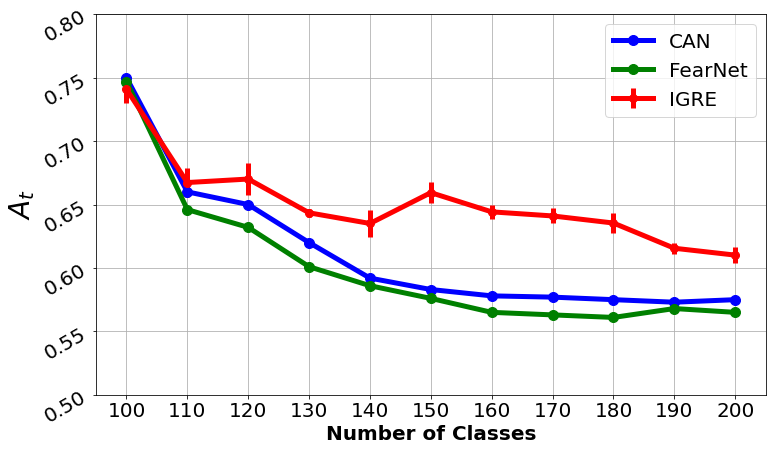

In [18]:
# from matplotlib import rc
# rc('font', weight='bold')

# pca_res = np.genfromtxt(f"out/split-cub/res101-nepoch30-nSample300-A10/cl_acc_it05.txt", delimiter=",")

# mask = pca_res == 0
# pca_res[mask] = np.nan
# arr = np.nanmean(pca_res, axis=1) / 100.

can_res = [0.75, 0.66, 0.65, 0.62, 0.592, 0.583, 0.578, 0.577, 0.575, 0.573, 0.575]
fearnet_res = [0.747, 0.646, 0.632, 0.601, 0.586, 0.576, 0.565, 0.563, 0.561, 0.568, 0.565]
icarl_res = [695, 65.3, 62.4, 60.4, 59.5]
# for idx in range(1,6):
#     pca_res = np.genfromtxt(f"out/cifar100-res50-300/cl_acc_it0{idx}.txt", delimiter=",")
#     pca_acc.append(np.mean(pca_res[-1]))
# res_lst.append(pca_acc)

tick_lab = [ii for ii in range(100, 205, 10)]
plt.figure(figsize=(12,7))
plt.errorbar(np.arange(11), all_res_mean, all_res_std, fmt="-ro", label="IGRE", linewidth=5, markersize=8)
# plt.plot(arr[:], "-ro", label="IGRE", linewidth=5, markersize=10)
plt.plot(can_res, "-bo", label="CAN", linewidth=5, markersize=10)
plt.plot(fearnet_res, "-go", label="FearNet", linewidth=5, markersize=10)
# plt.plot(icarl_res, "-go", label="iCARL")
# plt.xlabel(r"Task, $t$", fontsize=20)
plt.xlabel("Number of Classes", fontsize=20, fontweight='bold')
plt.xticks(np.arange(arr[:].shape[0]), labels=tick_lab, fontsize=20)
plt.ylabel(r"$A_t$", fontsize=28)
yticks = np.arange(0.5, 0.8, 0.05)
ylab =[f"{ii:.2f}" for ii in np.arange(0.5, 0.8, 0.05)]
plt.yticks(yticks, labels=ylab, fontsize=20, rotation=30)
plt.grid(True)
plt.legend(fontsize=20)
# plt.show()
plt.savefig("cub-prog-err.png", bbox_inches="tight")